2025-10-09 16:50:59,403	INFO worker.py:1917 -- Started a local Ray instance.
2025-10-09 16:51:05,085	INFO worker.py:1917 -- Started a local Ray instance.
2025-10-09 16:51:10,669	INFO worker.py:1917 -- Started a local Ray instance.


Text(0.5, 1.0, 'sum of abs(Wr)')

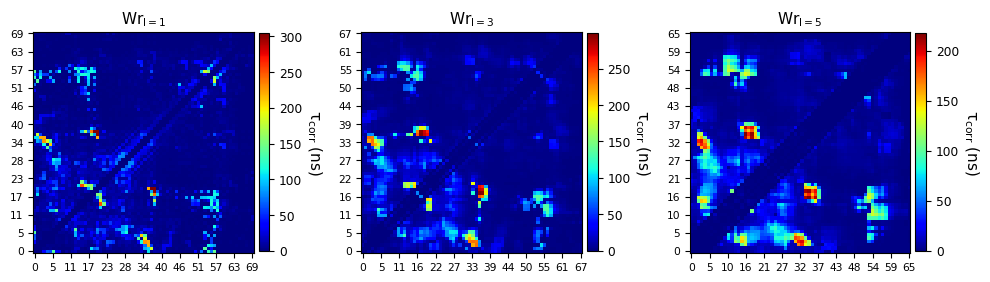

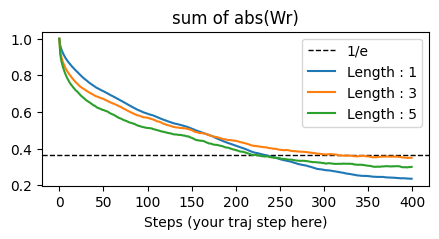

In [16]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import ray

from writhe_tools.writhe import Writhe, to_writhe_matrix
from writhe_tools.plots import plot_distance_matrix, lineplot1D
from writhe_tools.utils import symbols


def acf(x):
    """
    Computes the autocorrelation function (ACF) of a 1D time series using FFT.

    Parameters:
    - x (np.ndarray): Input 1D signal.

    Returns:
    - acf (np.ndarray): The autocorrelation function.
    """
    N = len(x)
    x = x - np.mean(x)
    return np.fft.ifft(np.abs(np.fft.fft(x, n=2*N))**2).real[:N] / (N * np.var(x))

def get_time(acf, cutoff=np.exp(-1)):

    return np.sum(acf[:(acf <= cutoff).argmax() + 1])
    
@ray.remote
def get_acf_time(x, cutoff=np.exp(-1)):
    return get_time(acf(x), cutoff=np.exp(-1))


traj_file, pdb = '/home/t/writhe/actr/ACTR-a99SBdisp-Traj.dcd', '/home/t/writhe/actr/actr.pdb'

lengths = [1,3,5]


xyz = md.load(traj_file, top=pdb,
              atom_indices=md.load(pdb).top.select("name CA")
              ).center_coordinates().xyz

writhe = Writhe(xyz)

writhes = [writhe.compute_writhe(length=i)['writhe_features'] for i in lengths]

correlation_times = [np.array(ray.get([get_acf_time.remote(i) for i in j.T])) for j in writhes]

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for wr, l, ax in zip(correlation_times, lengths, axes.flat):
    plot_distance_matrix(to_writhe_matrix(wr, xyz.shape[1], l).squeeze() * 0.2,
                         cmap="jet",
                         ax=ax,
                         cbar_label=rf"{symbols('tau')}$_{{corr}}$ (ns)",
                         title=fr"$\text{{Wr}}_{{l={l}}}$",#Wr_{l=}length {l}",
                         font_scale=1.1,
                         aspect="equal",
                         label_stride=5,
                         xticks_rotation=0,
                        )
plt.tight_layout()


abs_sum_acfs = [acf(abs(i).sum(-1)) for i in writhes]

fig, axes = plt.subplots(1, 1, figsize=(5, 2))
axes.axhline(y=1/np.exp(1),
                linestyle='--',
                color='black',
                linewidth=1,
                label='1/e',
               )

for wr, l in zip(abs_sum_acfs, lengths):
    axes.plot(wr[:400],label= f"Length : {l}")
axes.legend()
axes.set_xlabel("Steps (your traj step here)")
axes.set_title('sum of abs(Wr)')




#save_dict("correlation_matrices_truncated_integral.pkl", matrices)